In [1]:
import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets

In [2]:
from utils import Logger

In [12]:
def mnist_data():
    compose = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((.5,), (.5, ))
        ])
    out_dir = './dataset'
    return datasets.MNIST(root=out_dir, train=True, transform=compose, download=True)
# Load data
data = mnist_data()
# Create loader with data, so that we can iterate over it
data_loader = torch.utils.data.DataLoader(data, batch_size=100, shuffle=True)
# Num batches
num_batches = len(data_loader)

In [4]:
class DiscriminatorNet(torch.nn.Module):
    """
    A three hidden-layer discriminative neural network
    """
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_features = 784
        n_out = 1

        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
discriminator = DiscriminatorNet()

def images_to_vectors(images):
    return images.view(images.size(0), 784)

def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 1, 28, 28)

In [5]:
class GeneratorNet(torch.nn.Module):
    """
    A three hidden-layer generative neural network
    """
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 100
        n_out = 784

        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )

        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
generator = GeneratorNet()

In [6]:
def noise(size):
    '''
    Generates a 1-d vector of gaussian sampled random values
    '''
    n = Variable(torch.randn(size, 100))
    return n

In [7]:
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

def ones_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    return data

def zeros_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    return data

In [8]:
loss = nn.BCELoss()

In [14]:
def train_generator(optimizer, fake_data):
    N = fake_data.size(0)
    # Reset gradients
    optimizer.zero_grad()
    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    # Calculate error and backpropagate
    error = loss(prediction, ones_target(N))
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error

def train_discriminator(optimizer, real_data, fake_data):
    N = real_data.size(0)
    # Reset gradients
    optimizer.zero_grad()

    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data)
    # Calculate error and backpropagate
    error_real = loss(prediction_real, ones_target(N) )
    error_real.backward()

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, zeros_target(N))
    error_fake.backward()

    # 1.3 Update weights with gradients
    optimizer.step()

    # Return error and predictions for real and fake inputs
    return error_real + error_fake, prediction_real, prediction_fake

In [15]:
num_test_samples = 16
test_noise = noise(num_test_samples)

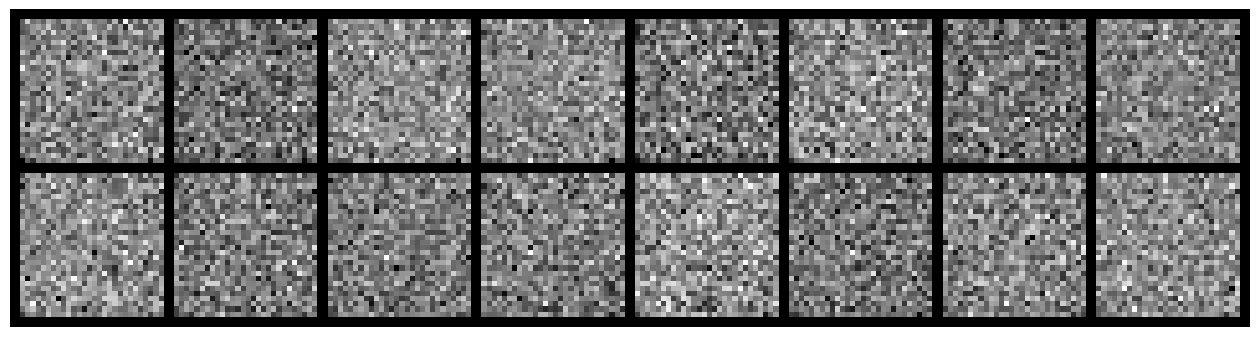

Epoch: [0/200], Batch Num: [0/600]
Discriminator Loss: 1.3566, Generator Loss: 0.6788
D(x): 0.5230, D(G(z)): 0.5074


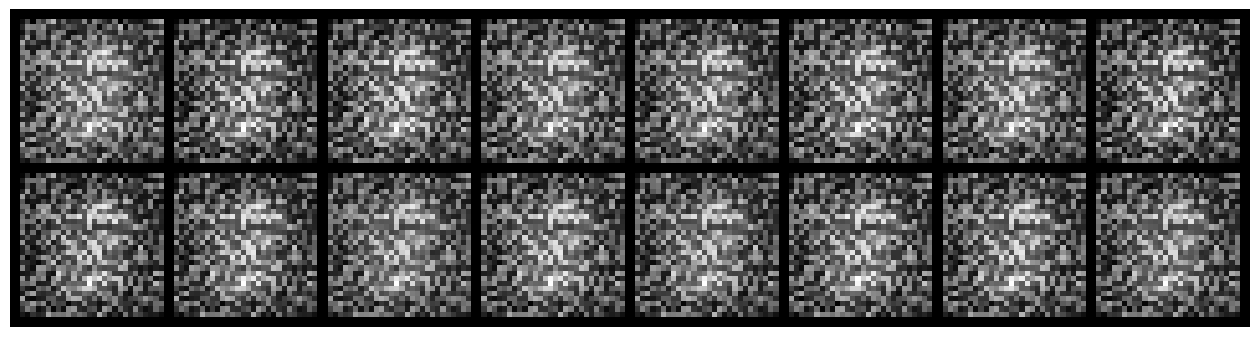

Epoch: [0/200], Batch Num: [100/600]
Discriminator Loss: 0.8617, Generator Loss: 1.9077
D(x): 0.7313, D(G(z)): 0.3218


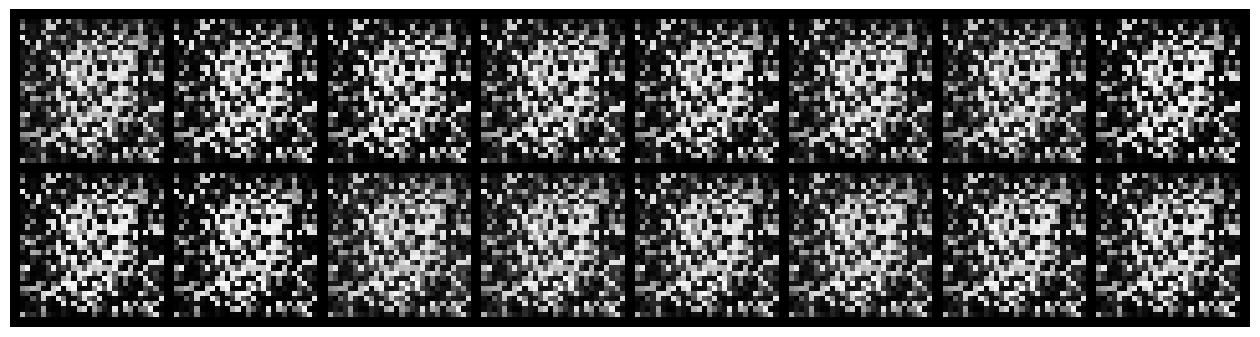

Epoch: [0/200], Batch Num: [200/600]
Discriminator Loss: 0.3745, Generator Loss: 3.3798
D(x): 0.9044, D(G(z)): 0.2102


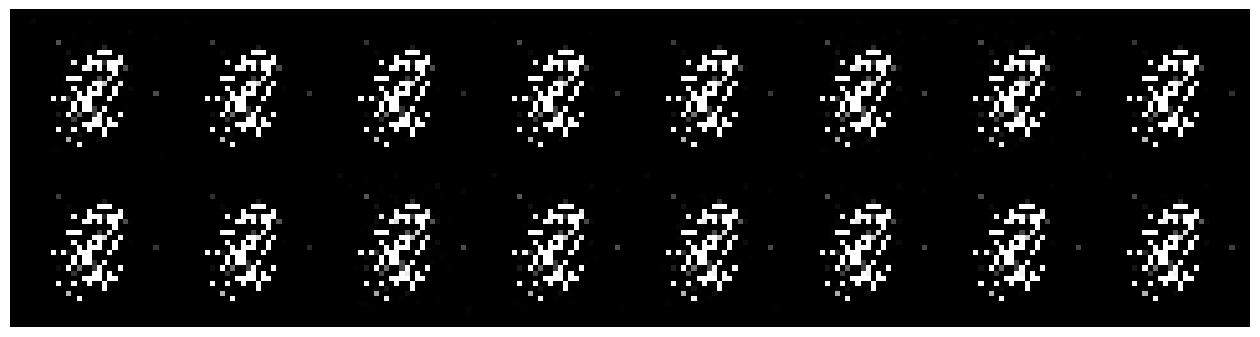

Epoch: [0/200], Batch Num: [300/600]
Discriminator Loss: 0.0175, Generator Loss: 5.7625
D(x): 0.9906, D(G(z)): 0.0079


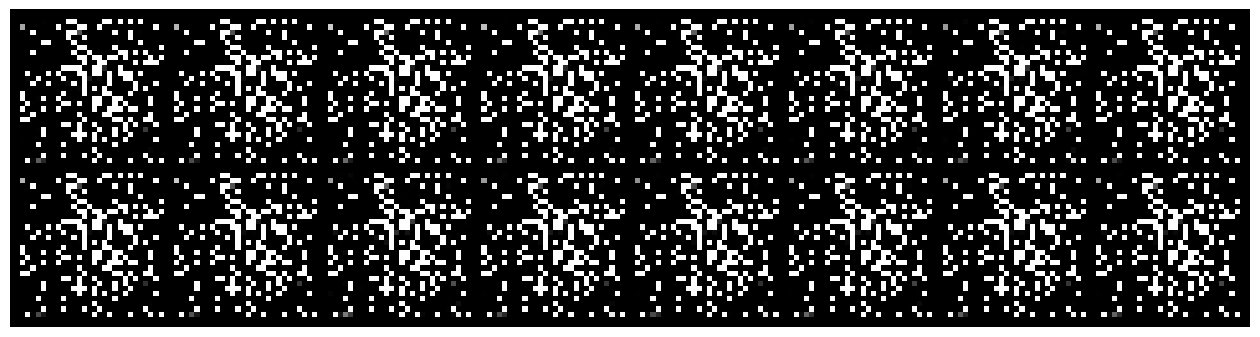

Epoch: [0/200], Batch Num: [400/600]
Discriminator Loss: 0.0048, Generator Loss: 11.0329
D(x): 0.9979, D(G(z)): 0.0025


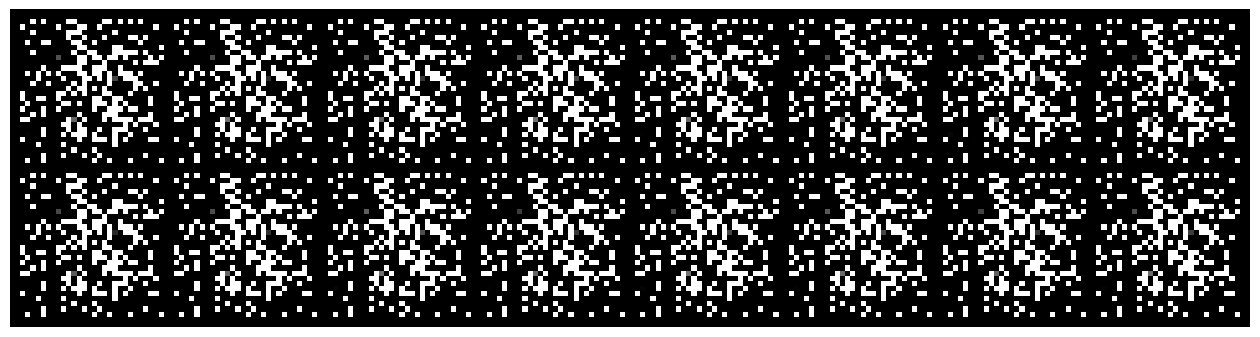

Epoch: [0/200], Batch Num: [500/600]
Discriminator Loss: 0.0013, Generator Loss: 11.3493
D(x): 0.9992, D(G(z)): 0.0005


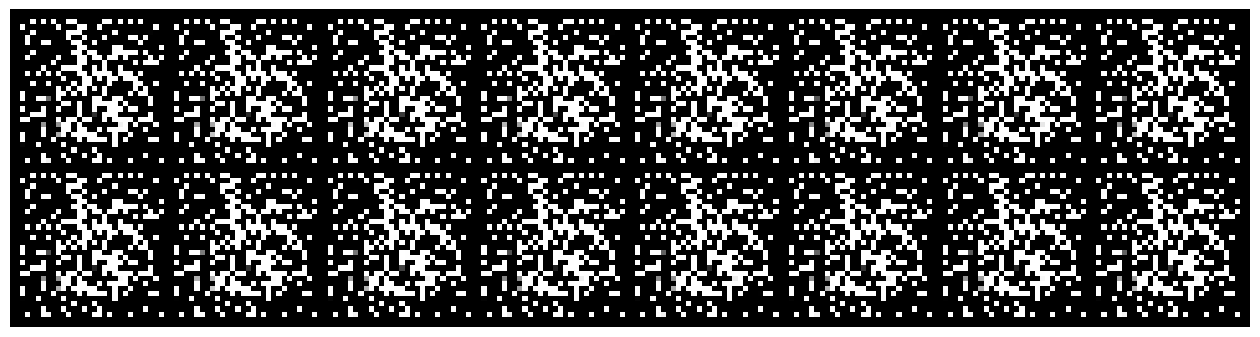

Epoch: [1/200], Batch Num: [0/600]
Discriminator Loss: 0.0018, Generator Loss: 11.7291
D(x): 0.9984, D(G(z)): 0.0002


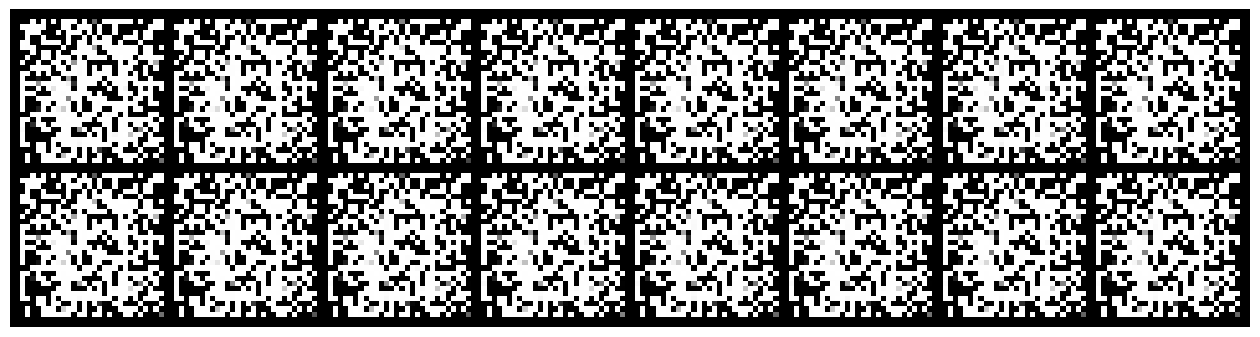

Epoch: [1/200], Batch Num: [100/600]
Discriminator Loss: 0.0010, Generator Loss: 8.6035
D(x): 0.9995, D(G(z)): 0.0005


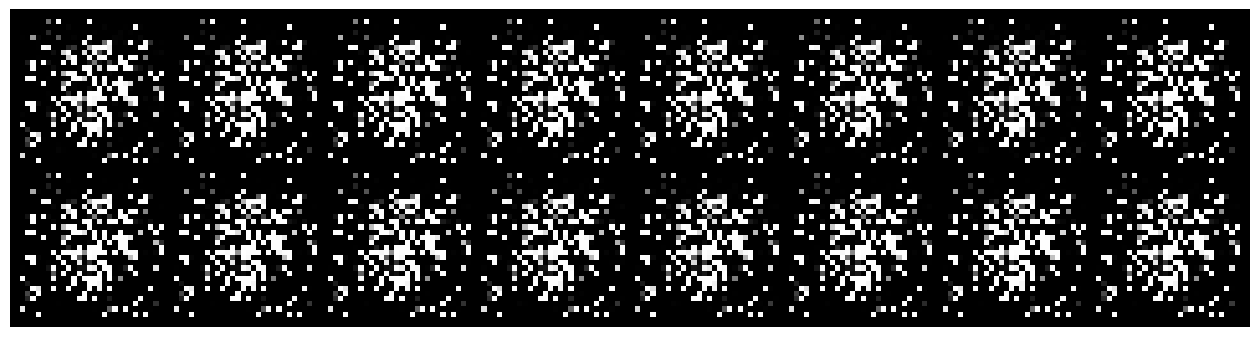

Epoch: [1/200], Batch Num: [200/600]
Discriminator Loss: 0.0325, Generator Loss: 7.2241
D(x): 0.9816, D(G(z)): 0.0113


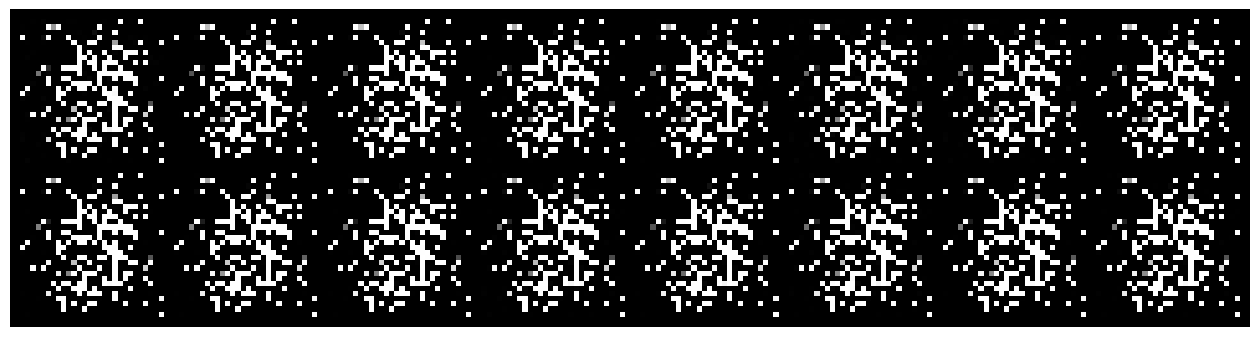

Epoch: [1/200], Batch Num: [300/600]
Discriminator Loss: 0.0193, Generator Loss: 9.8822
D(x): 0.9978, D(G(z)): 0.0124


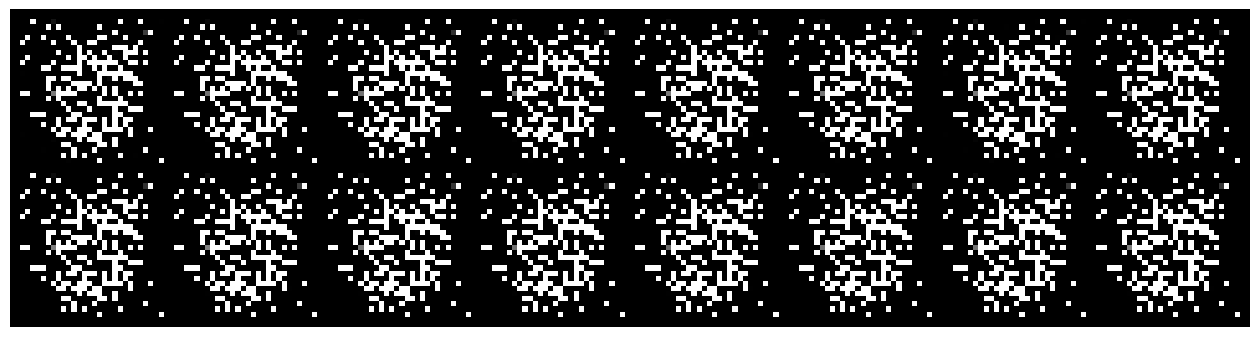

Epoch: [1/200], Batch Num: [400/600]
Discriminator Loss: 0.0006, Generator Loss: 11.7876
D(x): 0.9996, D(G(z)): 0.0001


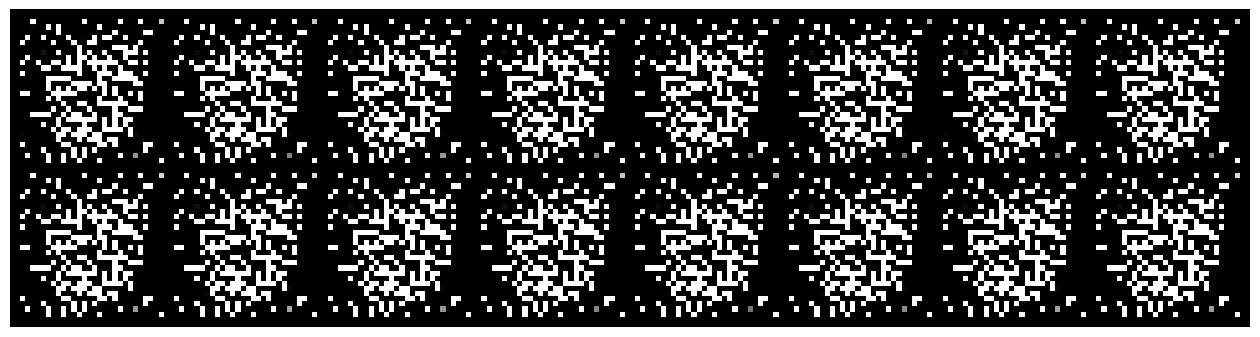

Epoch: [1/200], Batch Num: [500/600]
Discriminator Loss: 0.0005, Generator Loss: 12.2802
D(x): 0.9996, D(G(z)): 0.0001


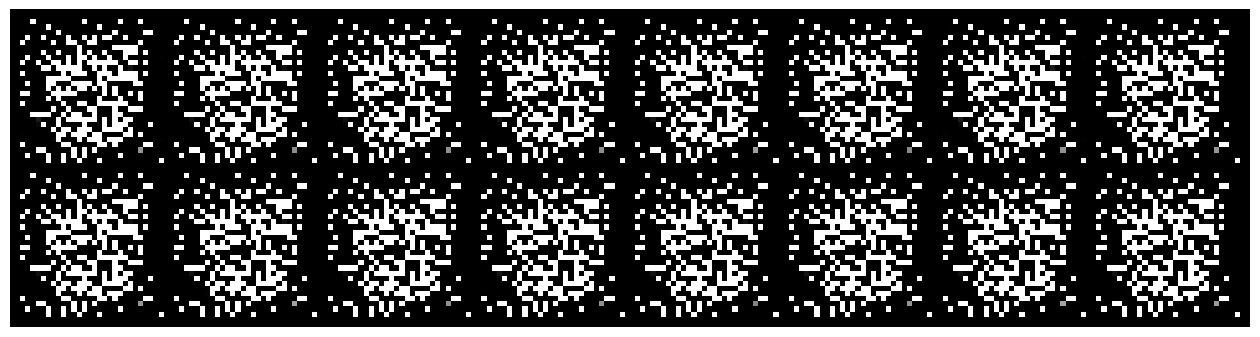

Epoch: [2/200], Batch Num: [0/600]
Discriminator Loss: 0.0004, Generator Loss: 11.5859
D(x): 0.9999, D(G(z)): 0.0002


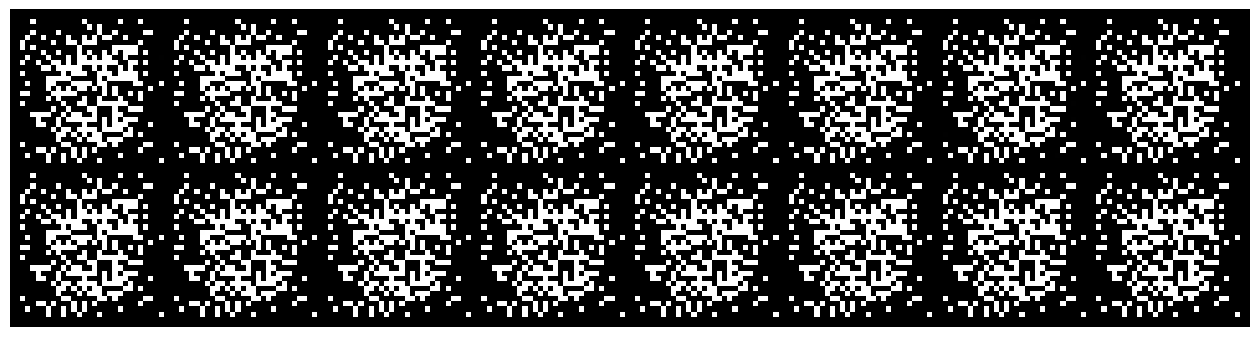

Epoch: [2/200], Batch Num: [100/600]
Discriminator Loss: 0.0004, Generator Loss: 11.0952
D(x): 0.9999, D(G(z)): 0.0002


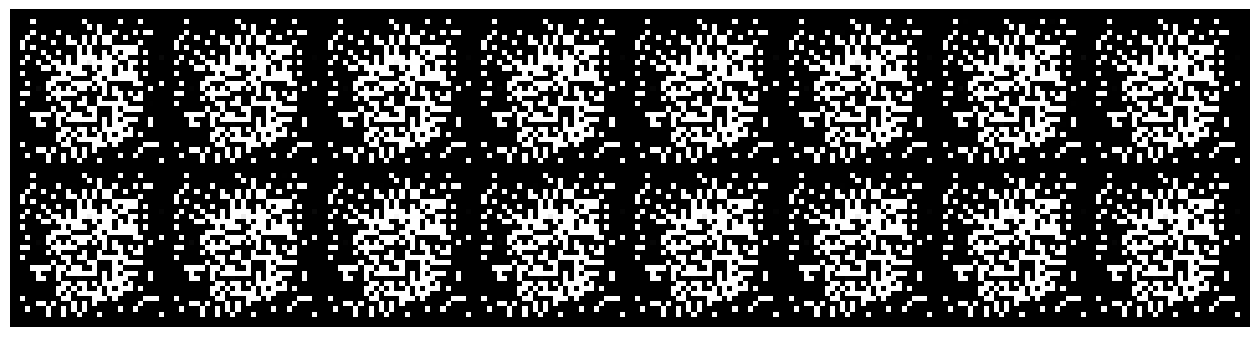

Epoch: [2/200], Batch Num: [200/600]
Discriminator Loss: 0.0002, Generator Loss: 10.8930
D(x): 0.9999, D(G(z)): 0.0001


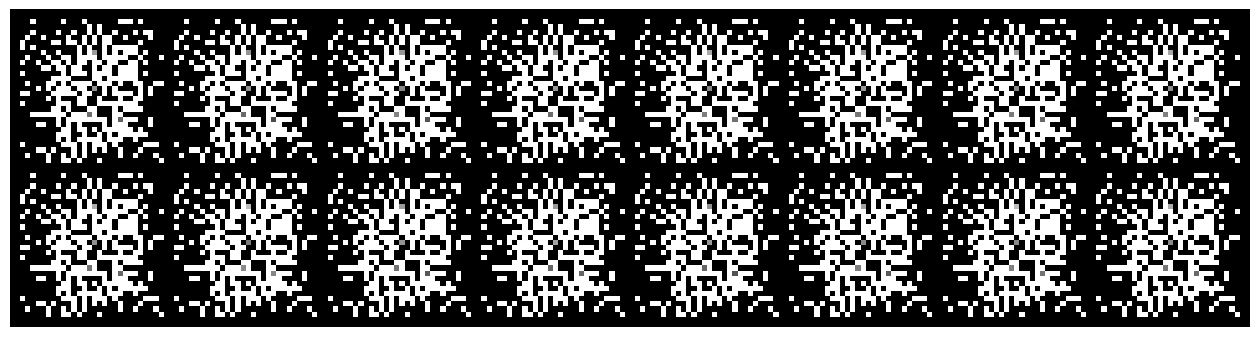

Epoch: [2/200], Batch Num: [300/600]
Discriminator Loss: 0.0007, Generator Loss: 11.8207
D(x): 0.9999, D(G(z)): 0.0006


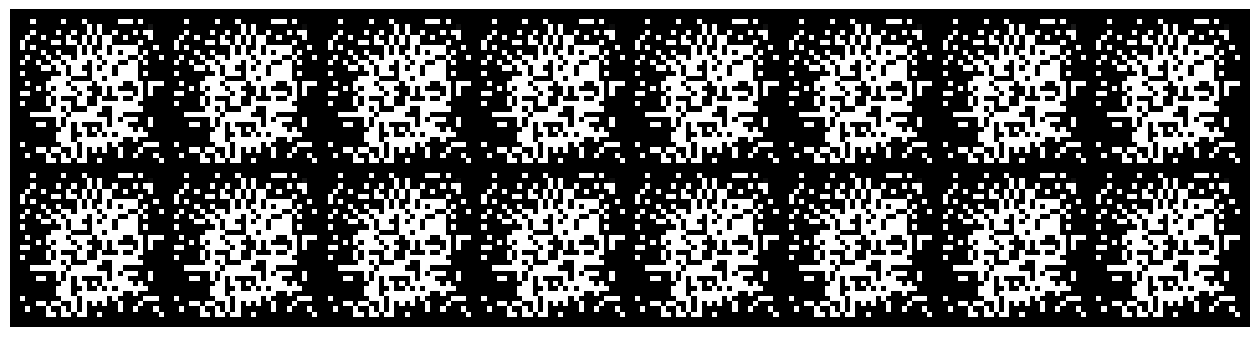

Epoch: [2/200], Batch Num: [400/600]
Discriminator Loss: 0.0001, Generator Loss: 12.5346
D(x): 0.9999, D(G(z)): 0.0000


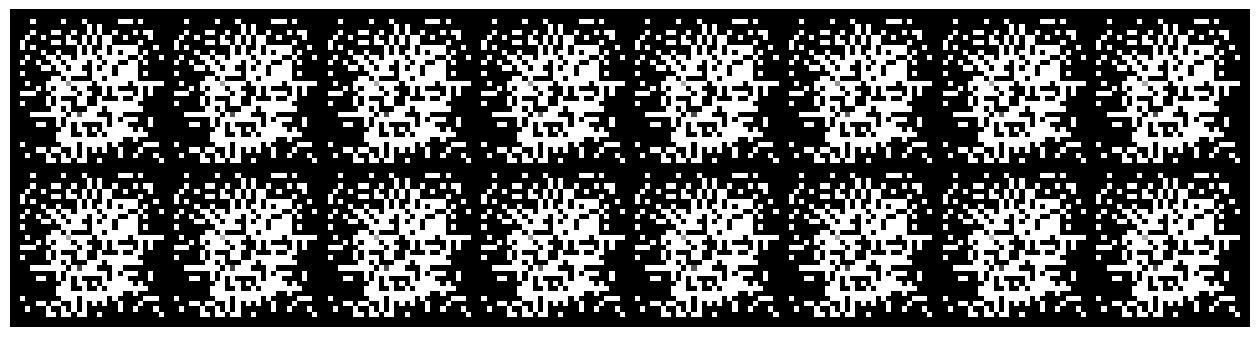

Epoch: [2/200], Batch Num: [500/600]
Discriminator Loss: 0.0001, Generator Loss: 12.5321
D(x): 1.0000, D(G(z)): 0.0000


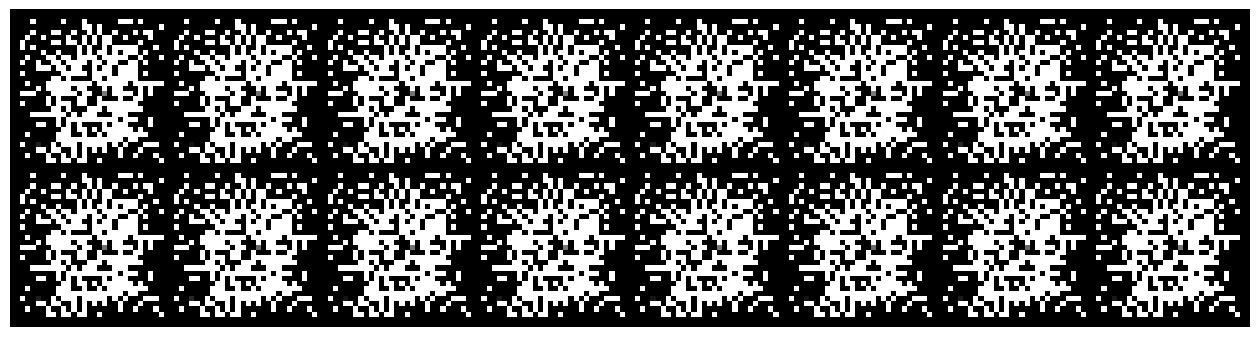

Epoch: [3/200], Batch Num: [0/600]
Discriminator Loss: 0.0000, Generator Loss: 13.4568
D(x): 1.0000, D(G(z)): 0.0000


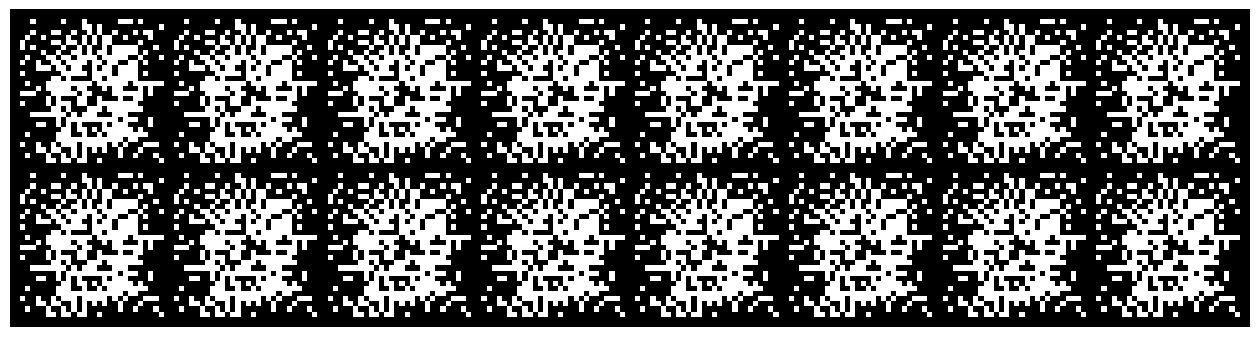

Epoch: [3/200], Batch Num: [100/600]
Discriminator Loss: 0.0001, Generator Loss: 14.2598
D(x): 1.0000, D(G(z)): 0.0000


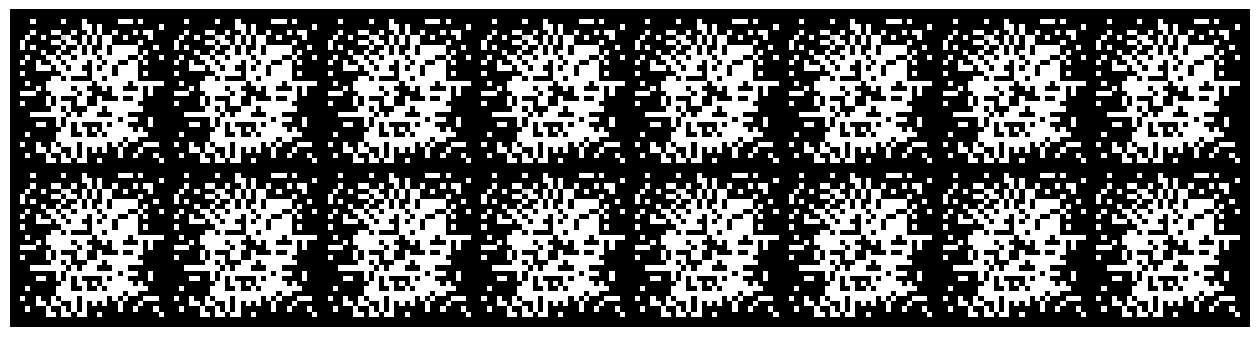

Epoch: [3/200], Batch Num: [200/600]
Discriminator Loss: 0.0000, Generator Loss: 14.8215
D(x): 1.0000, D(G(z)): 0.0000


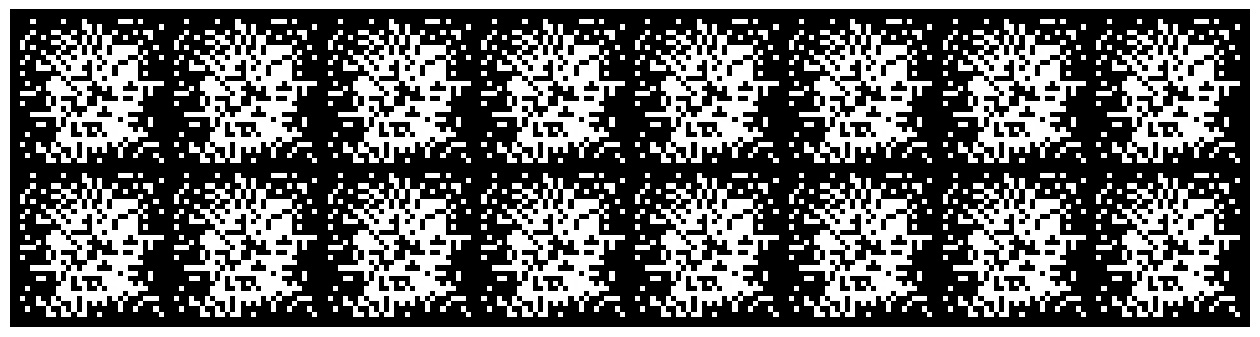

Epoch: [3/200], Batch Num: [300/600]
Discriminator Loss: 0.0000, Generator Loss: 15.0637
D(x): 1.0000, D(G(z)): 0.0000


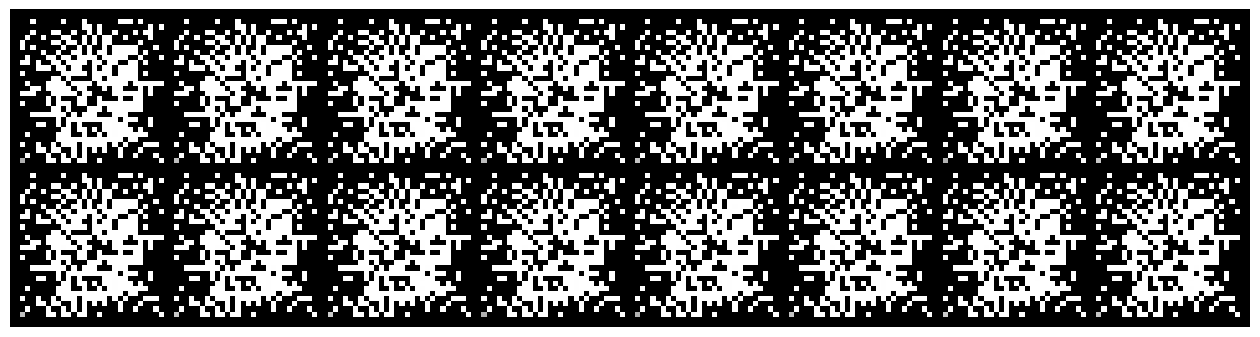

Epoch: [3/200], Batch Num: [400/600]
Discriminator Loss: 0.0000, Generator Loss: 15.1062
D(x): 1.0000, D(G(z)): 0.0000


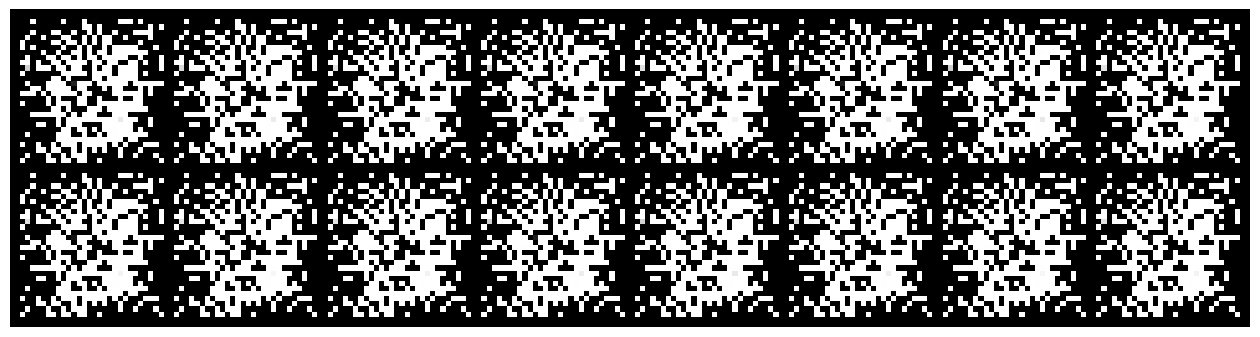

Epoch: [3/200], Batch Num: [500/600]
Discriminator Loss: 0.0001, Generator Loss: 12.2502
D(x): 1.0000, D(G(z)): 0.0000


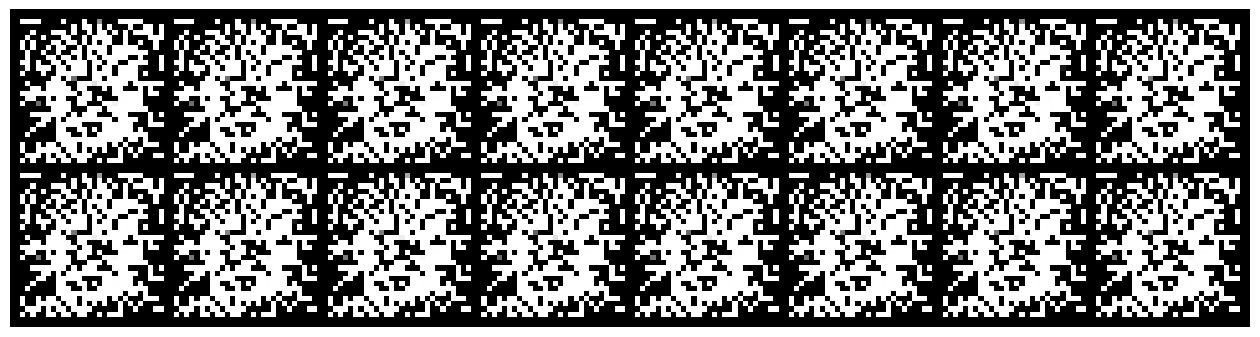

Epoch: [4/200], Batch Num: [0/600]
Discriminator Loss: 0.0002, Generator Loss: 10.5282
D(x): 1.0000, D(G(z)): 0.0001


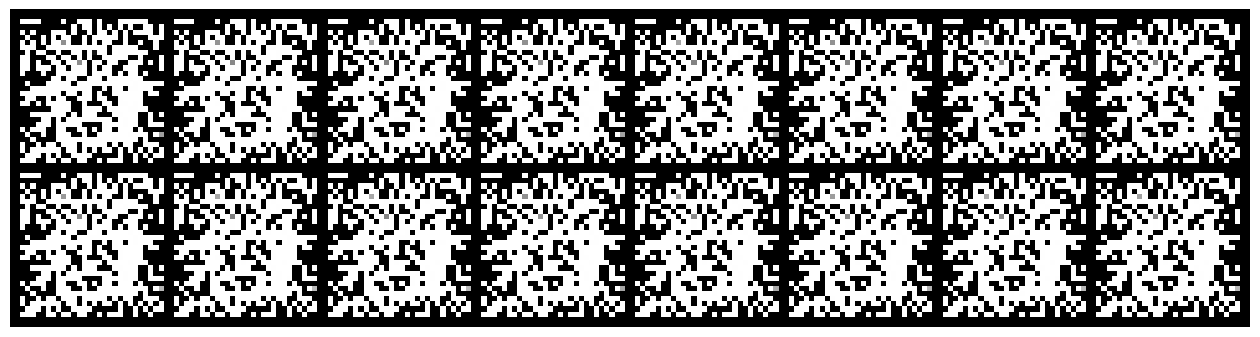

Epoch: [4/200], Batch Num: [100/600]
Discriminator Loss: 0.0001, Generator Loss: 12.6721
D(x): 1.0000, D(G(z)): 0.0000


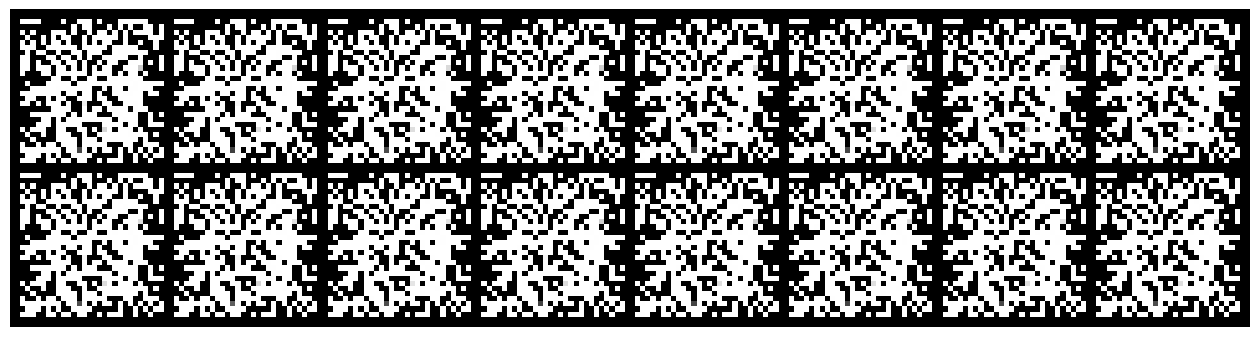

Epoch: [4/200], Batch Num: [200/600]
Discriminator Loss: 0.0001, Generator Loss: 11.4562
D(x): 1.0000, D(G(z)): 0.0001


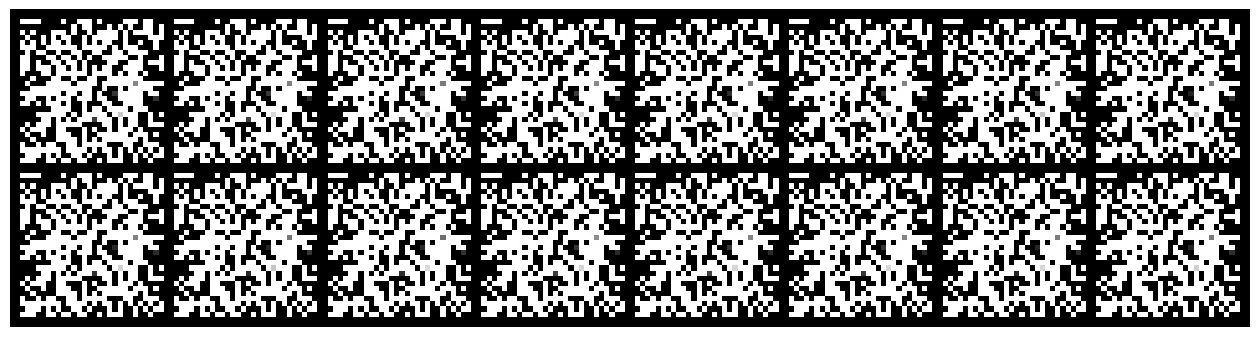

Epoch: [4/200], Batch Num: [300/600]
Discriminator Loss: 0.0001, Generator Loss: 10.8599
D(x): 1.0000, D(G(z)): 0.0001


KeyboardInterrupt: 

In [16]:
# Create logger instance
logger = Logger(model_name='VGAN', data_name='MNIST')
# Total number of epochs to train
num_epochs = 200
for epoch in range(num_epochs):
    for n_batch, (real_batch,_) in enumerate(data_loader):
        N = real_batch.size(0)
        # 1. Train Discriminator
        real_data = Variable(images_to_vectors(real_batch))
        # Generate fake data and detach
        # (so gradients are not calculated for generator)
        fake_data = generator(noise(N)).detach()
        # Train D
        d_error, d_pred_real, d_pred_fake = \
              train_discriminator(d_optimizer, real_data, fake_data)

        # 2. Train Generator
        # Generate fake data
        fake_data = generator(noise(N))
        # Train G
        g_error = train_generator(g_optimizer, fake_data)
        # Log batch error
        logger.log(d_error, g_error, epoch, n_batch, num_batches)
        # Display Progress every few batches
        if (n_batch) % 100 == 0:
            test_images = vectors_to_images(generator(test_noise))
            test_images = test_images.data
            logger.log_images(
                test_images, num_test_samples,
                epoch, n_batch, num_batches
            );
            # Display status Logs
            logger.display_status(
                epoch, num_epochs, n_batch, num_batches,
                d_error, g_error, d_pred_real, d_pred_fake
            )